In [9]:
import geopandas as geop

import torch
from torch import nn
import torch.nn.functional as F

import numpy as np

import seaborn as sns

from scipy import stats
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [4]:
raw_data = geop.read_file('./PlanBlocksR5_v2neighbors.shp')

In [10]:
from train import init_data, train, predict

In [11]:
init_data()
# train()

In [13]:
from visualize import Visualize, w_zgc, wangjing

In [68]:
v_neisum = Visualize('neisum')

In [162]:
v_neisum.statistics()

R^2 = 0.33710819586515595
Mean error = 0.8823335984421492
Mean level difference = 0.4065503575821072


/home/laekov/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


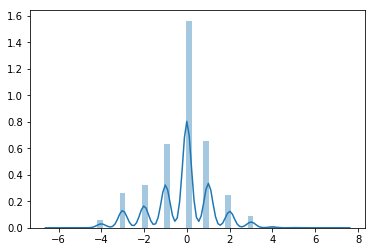

In [69]:
v_neisum.error_plot()

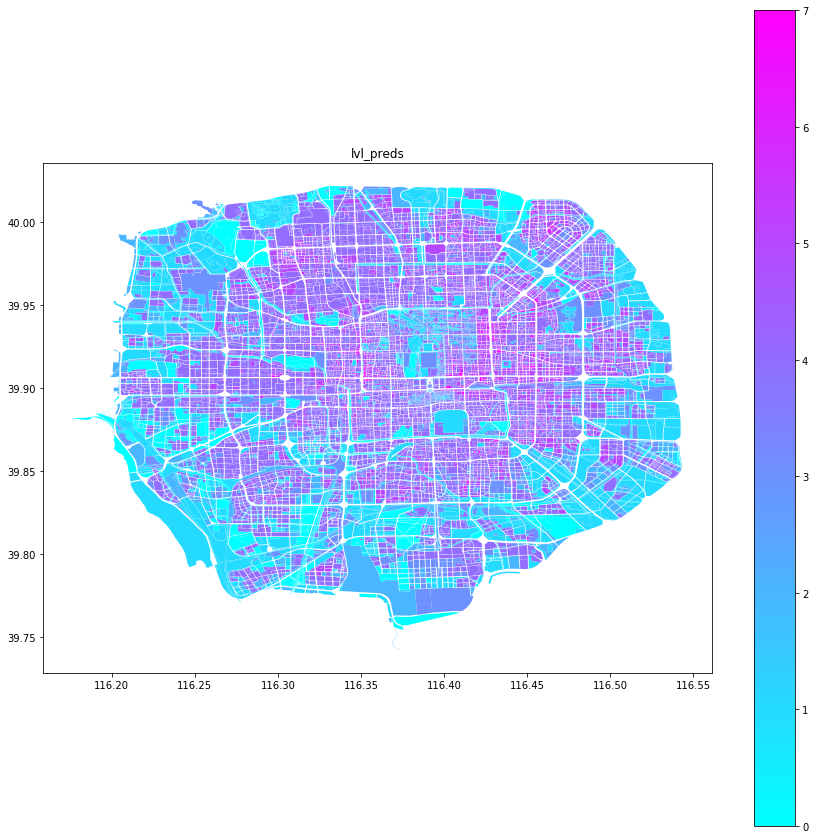

In [70]:
v_neisum.plot_map('lvl_preds')

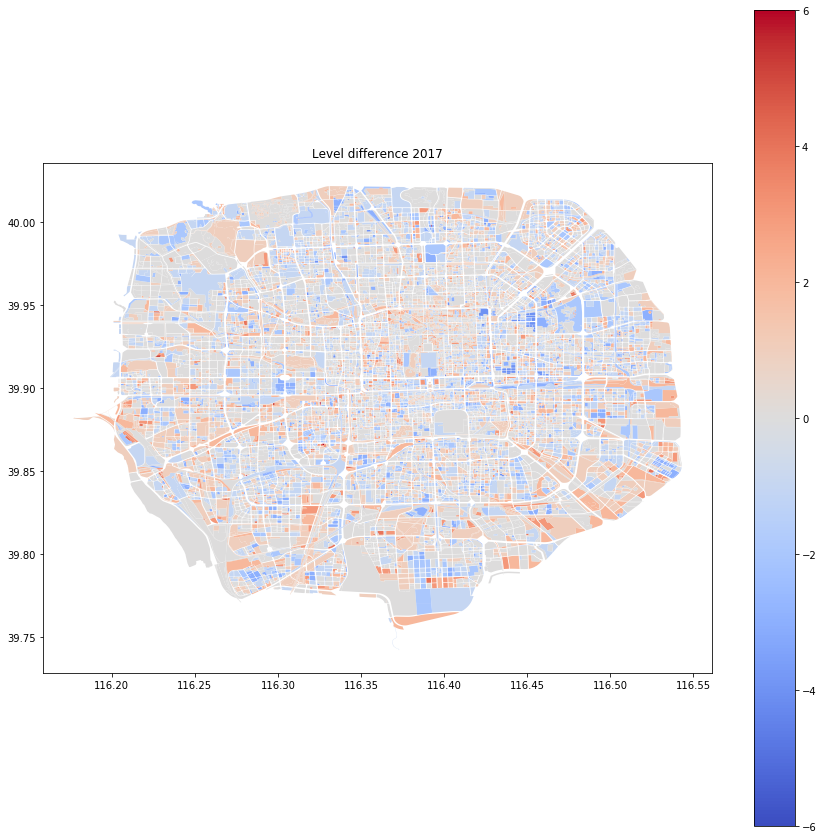

In [77]:
v_neisum.plot_whole_lvl_error()

In [123]:
v_mlp = Visualize('mlp')

/home/laekov/miniconda3/lib/python3.7/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and None
  other.crs))


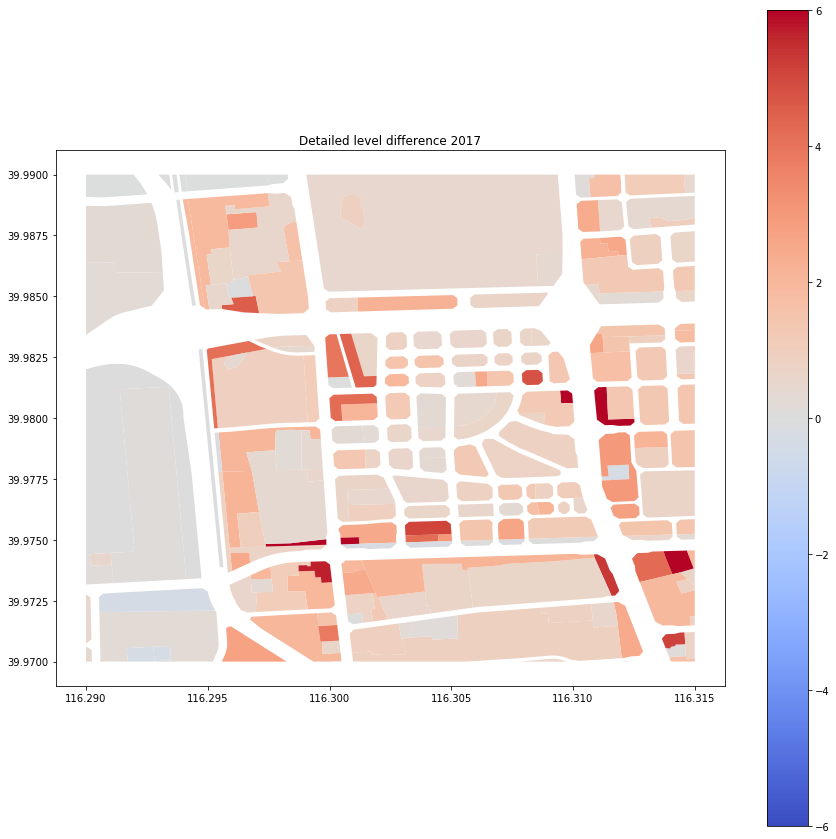

In [124]:
v_mlp.plot_district(w_zgc, 'predictions')

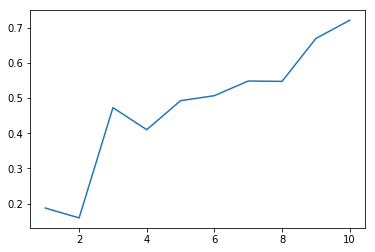

In [87]:
v_mlp.tam()

In [74]:
v_mlp.statistics()

R^2 = 0.1576158360834812
Mean error = 1.0193582431442054
Mean level difference = 0.39980868218466725


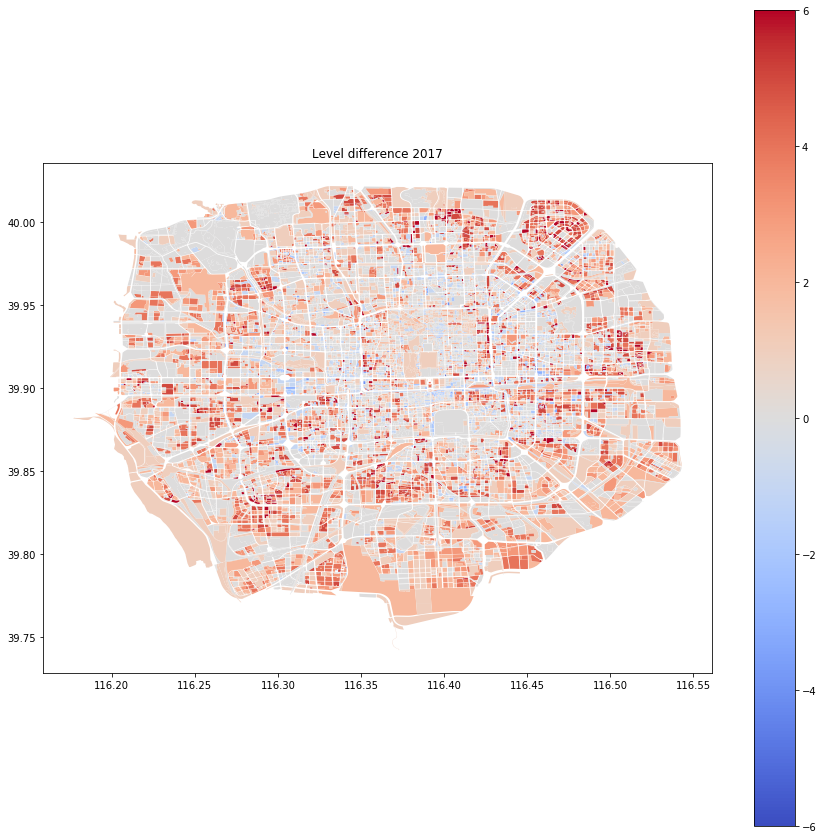

In [76]:
v_mlp.plot_whole_lvl_error()

In [14]:
v_neisumnow = Visualize('neiatt')
v_neisumnow.statistics()

R^2 = 0.17375509385435628
Mean error = 1.049596630912769
Mean level difference = 0.31758757345237554


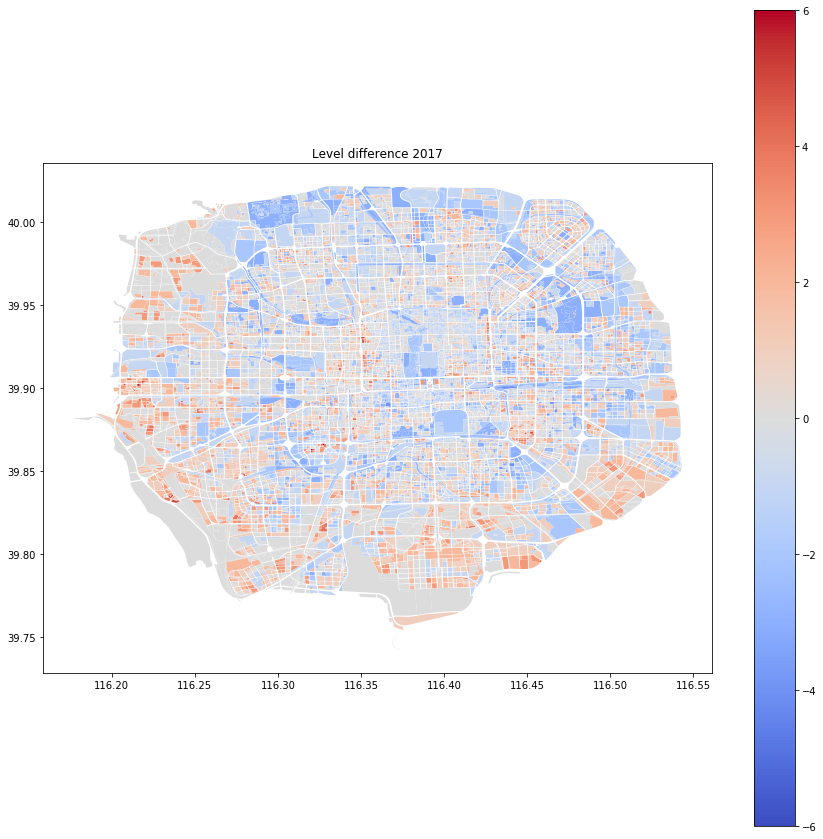

In [15]:
v_neisumnow.plot_whole_lvl_error()

/home/laekov/miniconda3/lib/python3.7/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and None
  other.crs))


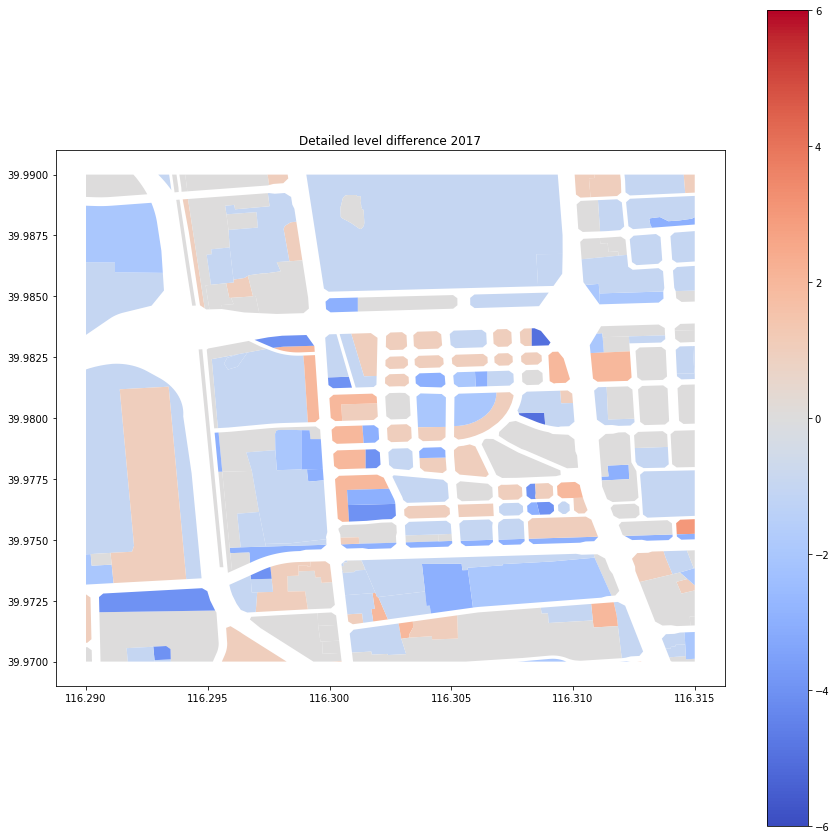

In [171]:
v_neisumnow.plot_district(w_zgc, 'lvlerror')
# v_neisumnow.plot_district(w_zgc, 'Far_2004')
# v_neisumnow.plot_district(w_zgc, 'Far_2017')

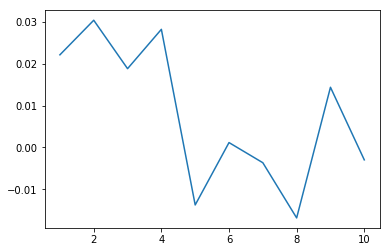

In [170]:
v_neisumnow.tam()

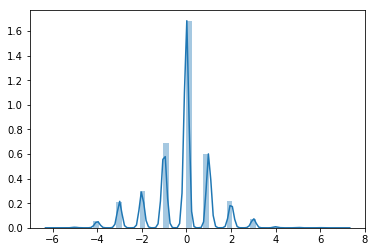

In [169]:
v_neisumnow.error_plot()